# 20240915
★ shot grid 수정해야함.  그냥 단순히 step pitch로 쪼개놓은것임.-> 개선필요

1. Shot Left부분 그리기. 
   wafer정센터(0,0)에서 step_pitch의 절반만큼 -방향으로 이동. 
   
2. map shift 고려. 
   map shift만큼을 더해준다.

3. +방향에서는 step pitch만큼 n개씩 더해준다. 
   -방향에서는 step pitch만큼 m개씩 빼준다. 

# 20240915(2)
함수로 변경해줌

# 20240916
1. WF7.5로 테스트 해보기. OCM이랑 비교용
2. 화살표 머리부분 크기 조정. headwidth=2, headlength=3
3. 양수die, 음수die 정보를 매뉴얼로 넣어줘야하는 문제있음 -> max die, min die 정보를 활용. 대신에 vline, hline으로 나눠줘야함.

4. die x,y가 음수인 경우에 for문이 돌지않음. -> min에는 abs처리함.
5. shot left만 그려주는거라서 shot right부분 짤리는 경우있음 -> max_die + 2 처리해줌.(넉넉하게)
6. Die 위치 플롯기능은 삭제함.  die좌표계와 wf좌표계랑 안맞음..



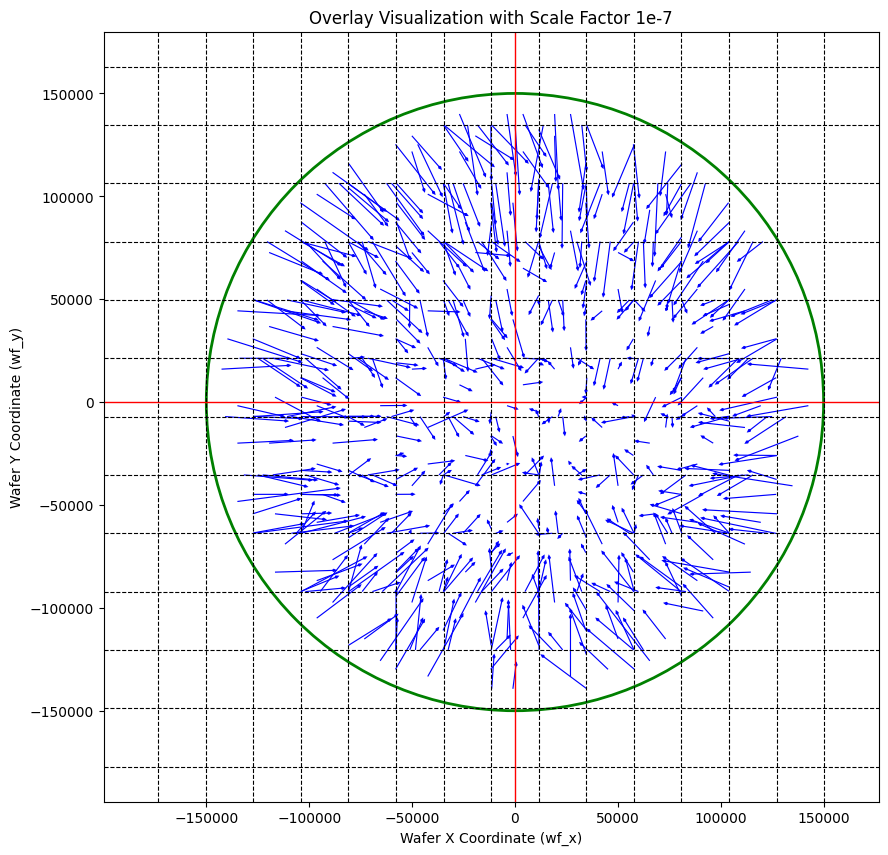

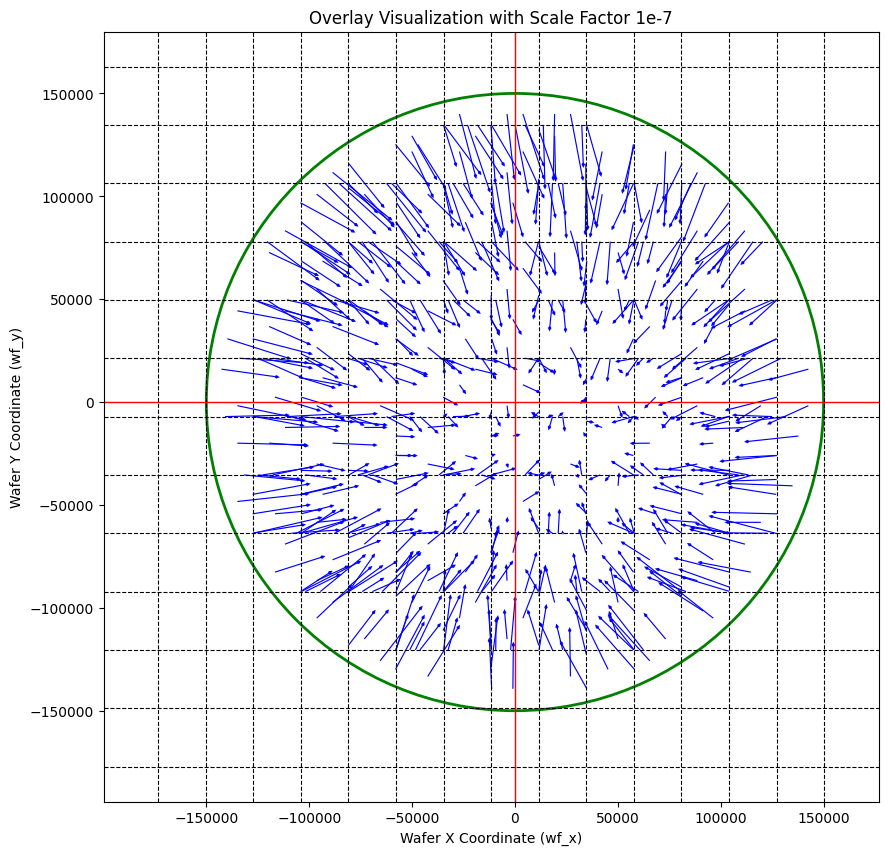

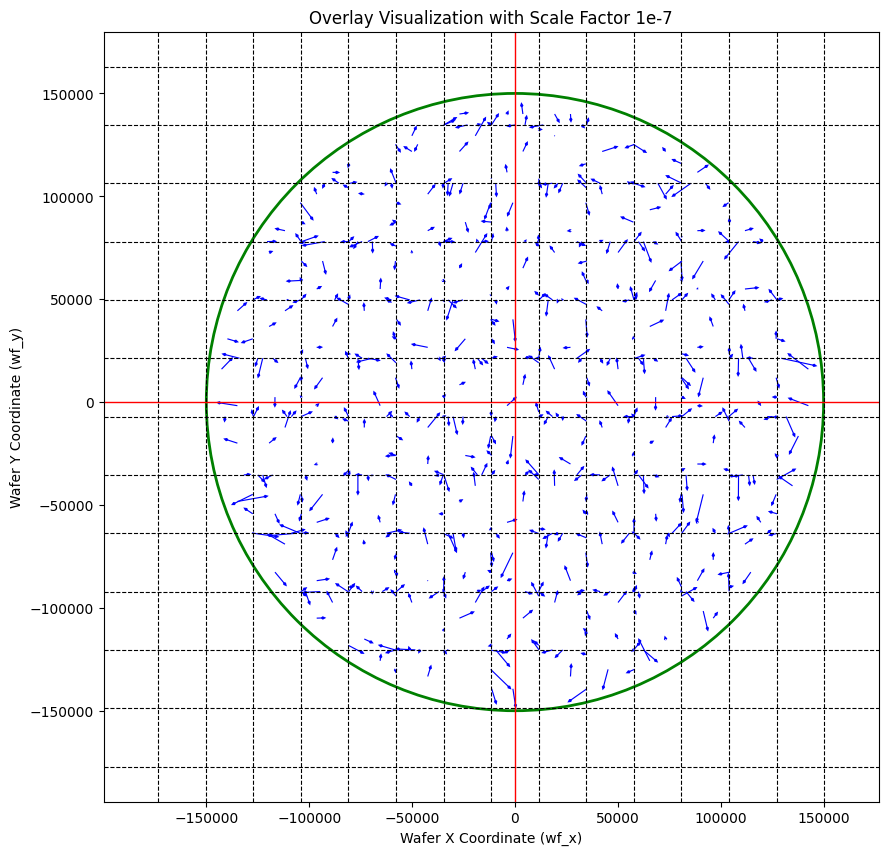

In [9]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 세로선을 계산하는 함수
def calculate_vlines(center, pitch, max_die_x, min_die_x):
    lines = []

    # 양의 방향
    current = center
    for _ in range(max_die_x + 2):  # max_die_x 방향으로 라인을 그리기 위한 반복
        lines.append(current)
        current += pitch

    # 음의 방향
    current = center
    for _ in range(abs(min_die_x) + 1):  # min_die_x의 절대값만큼 라인을 그리기 위한 반복
        current -= pitch
        lines.append(current)
    return lines



# 가로선을 계산하는 함수
def calculate_hlines(center, pitch, max_die_y, min_die_y ):
    lines = []
  
     # 양의 방향
    current = center
    for _ in range(max_die_y + 2):  # max_die_y 방향으로 라인을 그리기 위한 반복
        lines.append(current)
        current += pitch
    
    # 음의 방향
    current = center
    for _ in range(abs(min_die_y) + 1):  # min_die_y의 절대값만큼 라인을 그리기 위한 반복
        current -= pitch
        lines.append(current)
    return lines

# Overlay를 플롯하는 함수
def plot_overlay(x, y, dx, dy, v_lines, h_lines, die_x, die_y, wafer_radius=150000, title='Wafer Vector Map'):
    plt.figure(figsize=(10, 10))

    # Quiver 플롯
    plt.quiver(x, y, dx, dy, angles='xy', scale_units='xy', scale=1e-7, color='blue', label='Overlay Vectors',
               width=0.0015, headwidth=3, headlength=3)

    # 중앙선
    plt.axvline(0, color='red', linewidth=1.0, label='Central X')
    plt.axhline(0, color='red', linewidth=1.0, label='Central Y')

    # 수직선 추가
    for vline in v_lines:
        plt.axvline(vline, color='black', linestyle='--', linewidth=0.8)

    # 수평선 추가
    for hline in h_lines:
        plt.axhline(hline, color='black', linestyle='--', linewidth=0.8)

    # 웨이퍼 경계 원 추가
    wafer_circle = plt.Circle((0, 0), wafer_radius, color='green', fill=False, linestyle='-', linewidth=2, label='Wafer Boundary')
    plt.gca().add_patch(wafer_circle)

    
    # 축 설정 및 제목 추가
    plt.xlabel('Wafer X Coordinate (wf_x)')
    plt.ylabel('Wafer Y Coordinate (wf_y)')
    plt.title(title)
    plt.axis('equal')
    plt.grid(False)

    # 범례 추가
    # plt.legend()

    plt.show()

# 메인 스크립트
def main():
    # 엑셀 파일 읽기
    file_path = 'C:/vscode/MODULE/wafermap/output.xlsx'  # 실제 파일 경로로 업데이트
    sheet_name = 'RawData-1'

    # 엑셀 파일 읽기
    df = pd.read_excel(file_path, sheet_name=sheet_name)

    # 데이터 열 추출
    wf_x = df['wf_x']
    wf_y = df['wf_y']
    overlay_x = df['X_reg']
    overlay_y = df['Y_reg']
    fit_x = df['pred_x']
    fit_y = df['pred_y']
    residual_x = df['residual_x']
    residual_y = df['residual_y']
    die_x = df['DieX']
    die_y = df['DieY']

    # STEP_PITCH_X, STEP_PITCH_Y 추출
    step_pitch_x = df['STEP_PITCH_X'].iloc[0]
    step_pitch_y = df['STEP_PITCH_Y'].iloc[0]
    map_shift_x = df['MAP_SHIFT_X'].iloc[0]
    map_shift_y = df['MAP_SHIFT_Y'].iloc[0]
    start_left = -(step_pitch_x)/2 + map_shift_x
    start_bottom = -(step_pitch_y)/2 + map_shift_y
    max_die_x = max(df['DieX'])
    min_die_x = min(df['DieX'])
    max_die_y = max(df['DieY'])
    min_die_y = min(df['DieY']) 



    # 수직선 및 수평선 계산
    vertical_lines = calculate_vlines(start_left, step_pitch_x, max_die_x, min_die_x)
    horizontal_lines = calculate_hlines(start_bottom, step_pitch_y, max_die_y, min_die_y)
    

     # raw 플로팅
    plot_overlay(
        x=wf_x,
        y=wf_y,
        dx=overlay_x,
        dy=overlay_y,
        v_lines=vertical_lines,
        h_lines=horizontal_lines,
        die_x=die_x,
        die_y=die_y,
        wafer_radius=150000,
        title='Overlay Visualization with Scale Factor 1e-7'
    )

    # fit 플로팅
    plot_overlay(
        x=wf_x,
        y=wf_y,
        dx=fit_x,
        dy=fit_y,
        v_lines=vertical_lines,
        h_lines=horizontal_lines,
        die_x=die_x,
        die_y=die_y,
        wafer_radius=150000,
        title='Overlay Visualization with Scale Factor 1e-7'
    )
    # residual 플로팅
    plot_overlay(
        x=wf_x,
        y=wf_y,
        dx=residual_x,
        dy=residual_y,
        v_lines=vertical_lines,
        h_lines=horizontal_lines,
        die_x=die_x,
        die_y=die_y,
        wafer_radius=150000,
        title='Overlay Visualization with Scale Factor 1e-7'
    )

if __name__ == "__main__":
    main()
